In [1]:
import json
import random
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# Config
N = 10
SEED = 0

# Use project root explicitly so paths work regardless of notebook CWD
ROOT = Path("/home/bunne/projects/dataset_weighting_nn")

datasets = {
    "hypersim": {
        "emb_dir": ROOT / "artifacts/embeddings/hypersim",
        "retr_dir": ROOT / "artifacts/retrieval/hypersim",
    },
    "gta_sfm": {
        "emb_dir": ROOT / "artifacts/embeddings/gta_sfm",
        "retr_dir": ROOT / "artifacts/retrieval/gta_sfm",
    },
    "scannetpp": {
        "emb_dir": ROOT / "artifacts/embeddings/scannetpp",
        "retr_dir": ROOT / "artifacts/retrieval/scannetpp",
    },
}

openimages = {
    "emb_dir": ROOT / "artifacts/embeddings/openimages"
}

rng = random.Random(SEED)

In [3]:
# Helpers

def load_paths(jsonl_path):
    """Load image paths from our `paths.jsonl`.

    Supports both:
    - {"path": "/abs/or/rel/path"}  (most adapters)
    - {"rel_path": "..."}          (older Hypersim/waifu metadata)
    """
    jsonl_path = Path(jsonl_path)
    if not jsonl_path.is_file():
        raise FileNotFoundError(f"Missing paths jsonl: {jsonl_path} (cwd={Path.cwd()})")

    paths = []
    with jsonl_path.open("r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            obj = json.loads(line)
            p = obj.get("path") or obj.get("rel_path")
            if p is None:
                continue
            paths.append(p)
    return paths


def load_image(path, max_edge=512, *, strict=True):
    """Load an image for visualization; optionally skip unreadable files."""
    try:
        with Image.open(path) as im:
            img = im.convert("RGB")
    except Exception:
        if strict:
            raise
        return None

    w, h = img.size
    scale = max_edge / max(w, h)
    if scale < 1:
        img = img.resize((int(w * scale), int(h * scale)), Image.BICUBIC)
    return img

In [4]:
# Load metadata
oi_paths = load_paths(openimages["emb_dir"] / "paths.jsonl")
M = len(oi_paths)

oi_indices = rng.sample(range(M), N)

dataset_data = {}
for name, cfg in datasets.items():
    dataset_data[name] = {
        "paths": load_paths(cfg["emb_dir"] / "paths.jsonl"),
        "nn_idx": np.load(cfg["retr_dir"] / "nn_idx.npy"),
        "nn_sim": np.load(cfg["retr_dir"] / "nn_sim.npy"),
    }

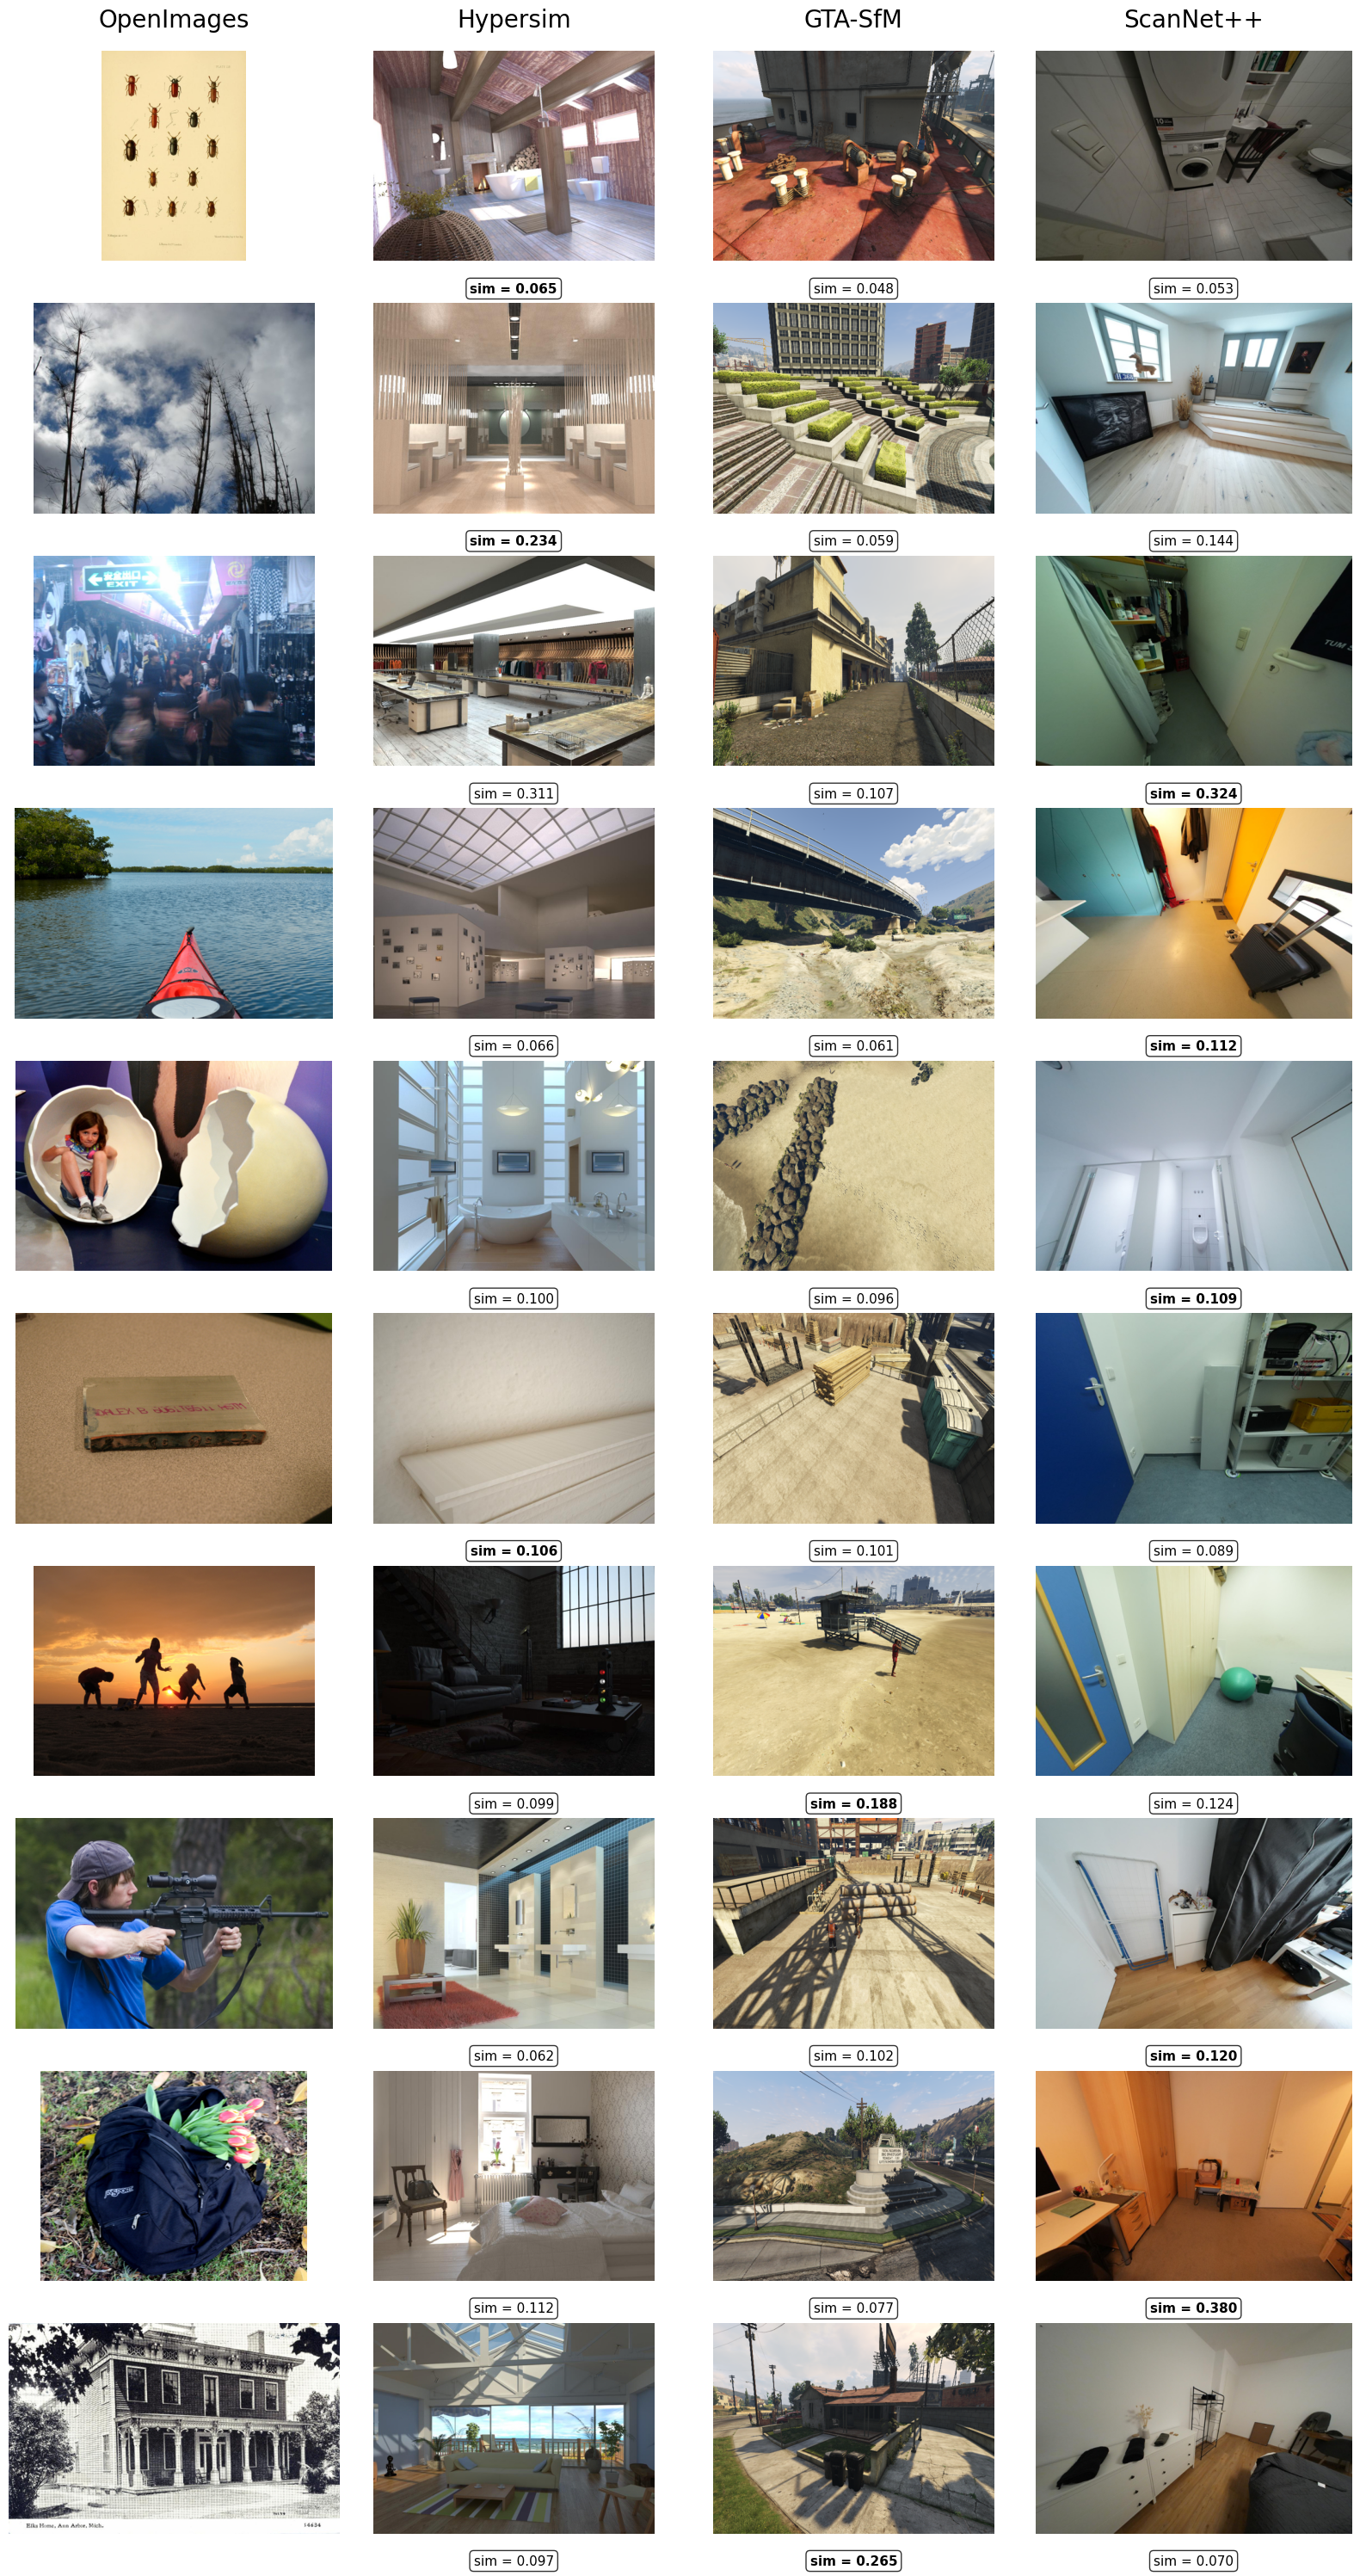

In [5]:
fig, axes = plt.subplots(N, 4, figsize=(16, 3 * N))

# Set column titles ONCE at the top
col_titles = ["OpenImages", "Hypersim", "GTA-SfM", "ScanNet++"]
for j, title in enumerate(col_titles):
    axes[0, j].set_title(title, fontsize=20, pad=20)  # Add padding to create space

for row, oi_i in enumerate(oi_indices):
    # Load OpenImages image
    oi_img = load_image(oi_paths[oi_i])
    axes[row, 0].imshow(oi_img)
    axes[row, 0].axis("off")
    
    # Add a label for OpenImages row (but not as title to avoid overlap)
    if row == 0:
        # This is already handled by the column title above
        pass

    # Collect sims for bolding
    sims = {}
    for name, data in dataset_data.items():
        sims[name] = float(data["nn_sim"][oi_i])

    max_dataset = max(sims, key=sims.get)

    # Plot each dataset match
    for col, name in enumerate(["hypersim", "gta_sfm", "scannetpp"], start=1):
        data = dataset_data[name]
        idx = data["nn_idx"][oi_i]
        sim = sims[name]

        img = load_image(data["paths"][idx])
        axes[row, col].imshow(img)
        axes[row, col].axis("off")

        weight = "bold" if name == max_dataset else "normal"
        # Add similarity score as a text label instead of title
        # Position it at the bottom of the image
        axes[row, col].text(
            0.5, -0.1, f"sim = {sim:.3f}",
            transform=axes[row, col].transAxes,
            ha='center',
            va='top',
            fontweight=weight,
            fontsize=11,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8)
        )

plt.tight_layout()
plt.subplots_adjust(hspace=0.2)  # Adjust vertical spacing
plt.show()